In [8]:
import sys
sys.path.append('/mnt/Work/LaGonaveFM/') # or use path 
sys.path.append('/home/aesgeorges/LaGonaveFM/')
from codebase.figures import *
from codebase.tools import *

import cmocean
import numpy as np
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
from kalpana.plotting import plot_nc
from kalpana.export import fort14togdf
from kalpana.ADCIRC_tools import extract_ts_from_nc
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib as mpl
import geopandas as gpd

import pandas as pd
import xarray as xr
import rasterio as rio
import rioxarray as rxr

#from cmcrameri import cm as cmc

# Analysis of Storm Surge and SLR runs

In [9]:
mangrove_scenario = 'Gonave_SLR_retreats/r0'
nomangrove_scenario = 'Gonave_SLR_retreats/r2'
root = f'../sims/{mangrove_scenario}/'
root_nomangrove = f'../sims/{nomangrove_scenario}/'

cities_extents = '../datasets/other/cities.shp'

In [10]:
import fiona
from shapely.geometry import shape
import pandas as pd

# Read the shapefile using fiona
with fiona.open(cities_extents, 'r') as src:
    cities = pd.DataFrame([feature['properties'] for feature in src])
    cities['geometry'] = [shape(feature['geometry']) for feature in src]

cities_gdf = gpd.GeoDataFrame(cities, geometry='geometry')
cities_gdf

,id,geometry
0,0,"POLYGON ((-72.65229 19.30147, -72.65162 19.301..."
1,1,"POLYGON ((-72.60486 19.31420, -72.60363 19.314..."
2,3,"POLYGON ((-72.69655 19.45433, -72.69628 19.455..."


## Import data from Baseline run

In [11]:
baseline_path = f'{root}S0/hotstart/maxele.63.nc'
base_data = netcdf.Dataset(baseline_path, 'r')

baseline_nomangrove_path = f'{root_nomangrove}S0/hotstart/maxele.63.nc'
base_data_nomangrove = netcdf.Dataset(baseline_nomangrove_path, 'r')

Max water level: 3.8737268081076164
Min water level: 0.12601537274866262


Text(0.5, 1.0, 'Max water level [mMSL] - Baseline')

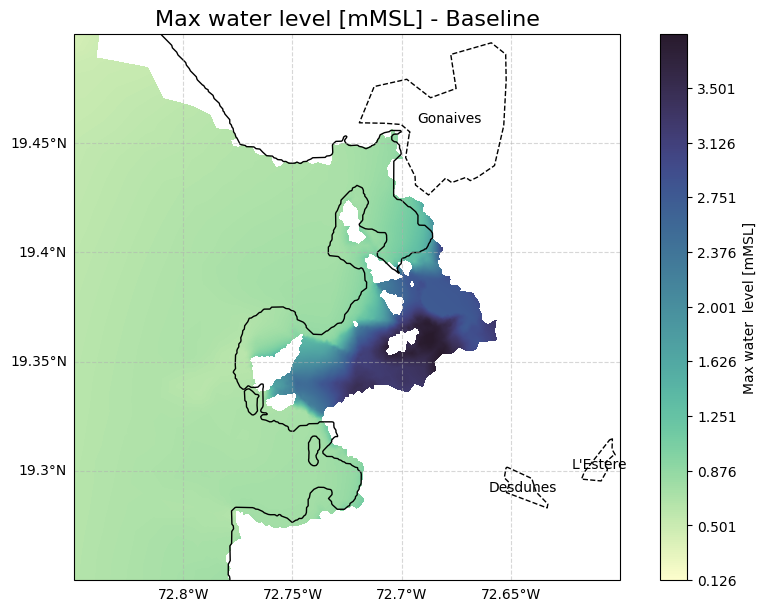

In [12]:
max_base = base_data.variables['zeta_max'][:].max()
min_base = base_data.variables['zeta_max'][:].min()
print(f'Max water level: {max_base}')
print(f'Min water level: {min_base}')

fig, ax = plt.subplots(figsize = (8,6), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)

#ax.add_image(osm_tiles, 15)

m = plot_nc(base_data, 'zeta_max', 
        levels=np.arange(min_base, max_base, 0.001), 
        background_map=False, cbar=True, 
        cb_label='Max water  level [mMSL]', 
        cmap=cmocean.cm.deep,
        extend='neither',
        fig=fig, ax=ax)

cities_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--', zorder=10)
cities = ['Desdunes', "L'Estere", 'Gonaives']
for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
        ax.text(x, y, str(label), fontsize=10, color='black', ha='center', va='center', zorder=11)

ax.set_extent([-72.85, -72.6, 19.25, 19.5], crs=ccrs.PlateCarree())


gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10)
gl.top_labels = False
gl.right_labels = False

coast = cf.GSHHSFeature(scale='full', levels=[1,2,3,4], alpha=1.0, edgecolor='black')
ax.add_feature(cf.LAKES)
ax.add_feature(coast)
ax.add_feature(cf.BORDERS, linestyle='--', alpha=0.5)
ax.set_title('Max water level [mMSL] - Baseline', fontsize=16)

Text(0.5, 1.0, 'Comparing Baseline Inundation Extents (Mangrove v No Mangrove)')

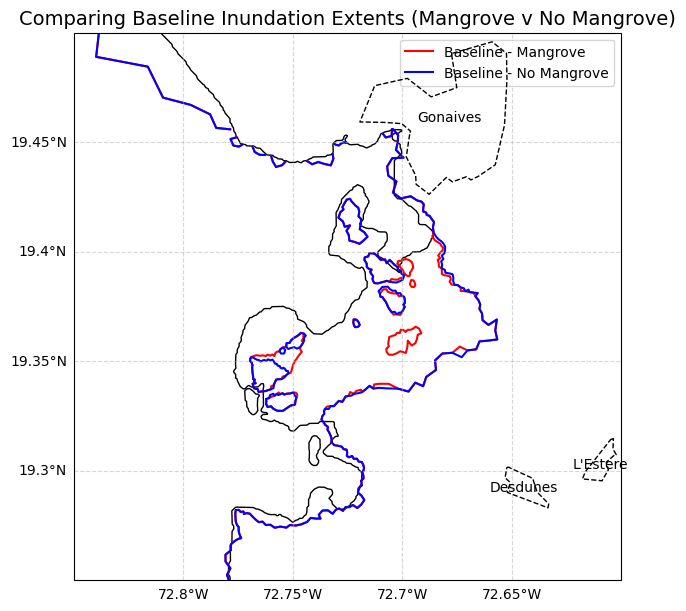

In [13]:
def plot_flood_extent(run, ax, color):
    tri = mpl.tri.Triangulation(run['x'][:].data, run['y'][:].data, run['element'][:,:] - 1)
    aux = run.variables['zeta_max'][:].data

    ax.tricontour(tri, aux, levels=0, colors=color, extend='neither')
    ax.set_xlim(-72.85, -72.6)
    ax.set_ylim(19.25, 19.5)

fig, ax = plt.subplots(figsize = (8,6), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)

custom_gradient = ["#FF0000", "#0004FF"]

plot_flood_extent(base_data, ax, custom_gradient[0])
plot_flood_extent(base_data_nomangrove, ax, custom_gradient[1])

ax.legend(handles=[mpl.lines.Line2D([], [], color=custom_gradient[0], label=f'Baseline - Mangrove'),
                   mpl.lines.Line2D([], [], color=custom_gradient[1], label=f'Baseline - No Mangrove')], loc='upper right')

cities_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--', zorder=10)
cities = ['Desdunes', "L'Estere", 'Gonaives']
for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
        ax.text(x, y, str(label), fontsize=10, color='black', ha='center', va='center', zorder=11)

ax.set_xlim(-72.85, -72.6)
ax.set_ylim(19.25, 19.5)

gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10) 
gl.top_labels = False
gl.right_labels = False

coast = cf.GSHHSFeature(scale='full', levels=[1,2,3,4], alpha=1.0, edgecolor='black')
ax.add_feature(cf.LAKES)
ax.add_feature(coast)

ax.set_title(f'Comparing Baseline Inundation Extents (Mangrove v No Mangrove)', fontsize=14)

## Import data from all SLR scenarios

In [14]:
scenarios = ['SSP2', 'SSP5'] #['SSP1', 'SSP2', 'SSP3', 'SSP5']
horizons = ['2030', '2100'] #['2030', '2050', '2070', '2100']

data = {}
data_nomangrove = {}

def load_data(scenario, horizon, dict, root):

    for scenario in scenarios:
        dict[scenario] = {}
        for horizon in horizons:
            file_path = f'{root}{scenario}_{horizon}/hotstart/maxele.63.nc'
            dict[scenario][horizon] = netcdf.Dataset(file_path, 'r')
    return dict

data = load_data(scenarios, horizons, data, root)
data_nomangrove = load_data(scenarios, horizons, data_nomangrove, root_nomangrove)

SLR Run Example

Max water level: 5.100598378475954
Min water level: 0.9660715006769065


Text(0.5, 1.0, 'Max water level [mMSL] - SSP5_2100')

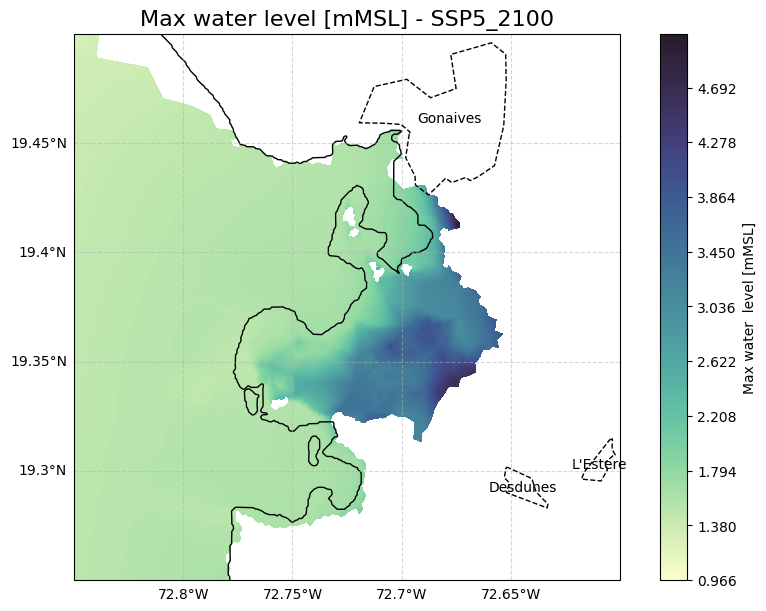

In [15]:
scenario = 'SSP5'
year = '2100'

run = data[scenario][year]

max = run.variables['zeta_max'][:].max()
min = run.variables['zeta_max'][:].min()
print(f'Max water level: {max}')
print(f'Min water level: {min}')

fig, ax = plt.subplots(figsize = (8,6), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)

#ax.add_image(osm_tiles, 15)

m = plot_nc(run, 'zeta_max', 
        levels=np.arange(min, max, 0.001), 
        background_map=False, cbar=True, 
        cb_label='Max water  level [mMSL]', 
        cmap=cmocean.cm.deep,
        extend='neither',
        fig=fig, ax=ax)

cities_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--', zorder=10)
cities = ['Desdunes', "L'Estere", 'Gonaives']
for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
        ax.text(x, y, str(label), fontsize=10, color='black', ha='center', va='center', zorder=11)

ax.set_extent([-72.85, -72.6, 19.25, 19.5], crs=ccrs.PlateCarree())


gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10)
gl.top_labels = False
gl.right_labels = False 

coast = cf.GSHHSFeature(scale='full', levels=[1,2,3,4], alpha=1.0, edgecolor='black')
ax.add_feature(cf.LAKES)
ax.add_feature(coast)
ax.add_feature(cf.BORDERS, linestyle='--', alpha=0.5)
ax.set_title(f'Max water level [mMSL] - {scenario}_{year}', fontsize=16)

Difference Map Example

Text(0.5, 1.0, 'Inundation Extent Evolution for SSP5')

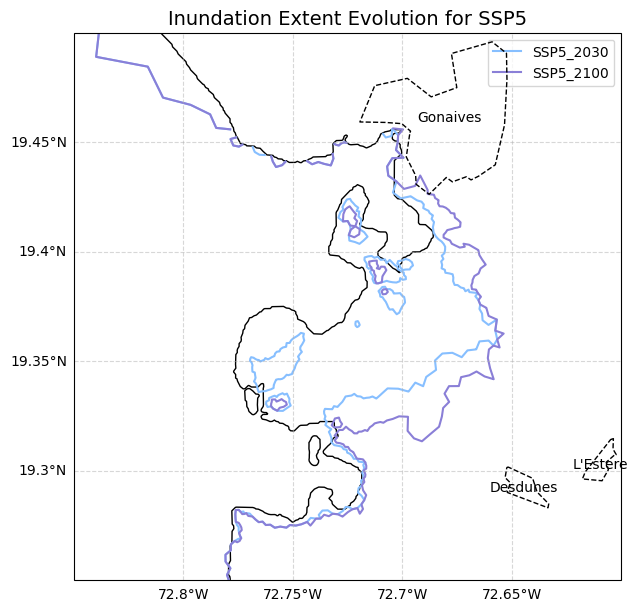

In [16]:
def plot_flood_extent(run, ax, color, scenario, year):
    tri = mpl.tri.Triangulation(run['x'][:].data, run['y'][:].data, run['element'][:,:] - 1)
    aux = run.variables['zeta_max'][:].data

    ax.tricontour(tri, aux, levels=0, colors=color, extend='neither')
    ax.set_xlim(-72.85, -72.6)
    ax.set_ylim(19.25, 19.5)

fig, ax = plt.subplots(figsize = (8,6), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)

scenario = 'SSP5'

custom_gradient = ['#87BFFF', '#8A7FD7', '#8C40B0', '#8F0088']

for i, year in enumerate(horizons):
    plot_flood_extent(data_nomangrove[scenario][year], ax, custom_gradient[i], scenario, year)

cities_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--', zorder=10)
cities = ['Desdunes', "L'Estere", 'Gonaives']
for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
        ax.text(x, y, str(label), fontsize=10, color='black', ha='center', va='center', zorder=11)

ax.legend(handles=[mpl.lines.Line2D([], [], color=color, label=f'{scenario}_{year}') for color, year in zip(custom_gradient, horizons)], loc='upper right')
ax.set_xlim(-72.85, -72.6)
ax.set_ylim(19.25, 19.5)

gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10) 
gl.top_labels = False
gl.right_labels = False

coast = cf.GSHHSFeature(scale='full', levels=[1,2,3,4], alpha=1.0, edgecolor='black')
ax.add_feature(cf.LAKES)
ax.add_feature(coast)

ax.set_title(f'Inundation Extent Evolution for {scenario}', fontsize=14)

## Surge Elevations

In [17]:
max_elevs = pd.DataFrame(index=horizons, columns=scenarios)
min_elevs = pd.DataFrame(index=horizons, columns=scenarios)

for scenario in scenarios:
    maxele = []
    minele = []
    for year in horizons:
        run = data[scenario][year]
        maxele.append(run.variables['zeta_max'][:].max())
        minele.append(run.variables['zeta_max'][:].min())
    max_elevs[scenario] = maxele
    min_elevs[scenario] = minele

max_elevs

,SSP2,SSP5
2030,3.958268,3.958268
2100,4.701683,5.100598


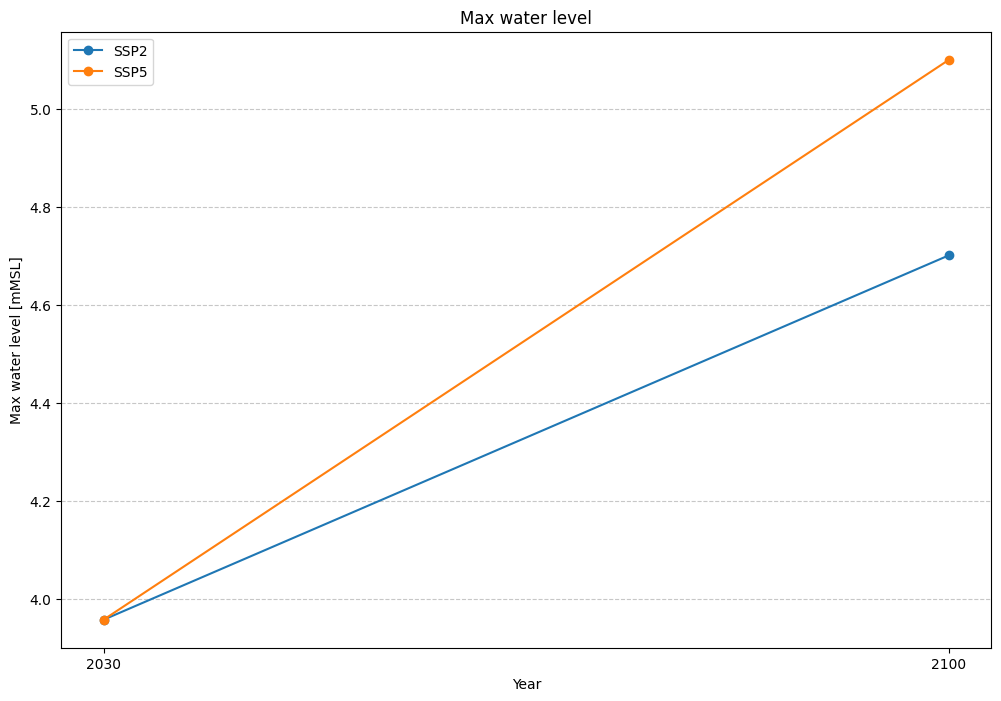

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
max_elevs.plot(ax=ax, marker='o')
ax.set_title('Max water level')
ax.set_ylabel('Max water level [mMSL]')
ax.set_xlabel('Year')
ax.set_xticks(range(len(horizons)))
ax.set_xticklabels(horizons)root = f'../sims/{mangrove_scenario}/'pha=0.7)

Surge Level

In [51]:
SLR_projections = pd.DataFrame(index=horizons, columns=scenarios)
SLR_projections = pd.DataFrame({
    'SSP1': [0.12, 0.24, 0.36, 0.53],
    'SSP2': [0.12, 0.26, 0.41, 0.67],
    'SSP3': [0.12, 0.26, 0.43, 0.77],
    'SSP5': [0.12, 0.28, 0.47, 0.86]
}, index=horizons)

ValueError: Length of values (4) does not match length of index (2)

In [ ]:
surge_levels = max_elevs - SLR_projections
surge_levels

,SSP1,SSP2,SSP3,SSP5
2030,3.821371,3.821371,3.821371,3.821371
2050,3.748234,3.786273,3.786273,3.711894
2070,3.592500,3.668053,3.664285,4.148267
2100,4.159779,3.793817,4.160575,4.240902


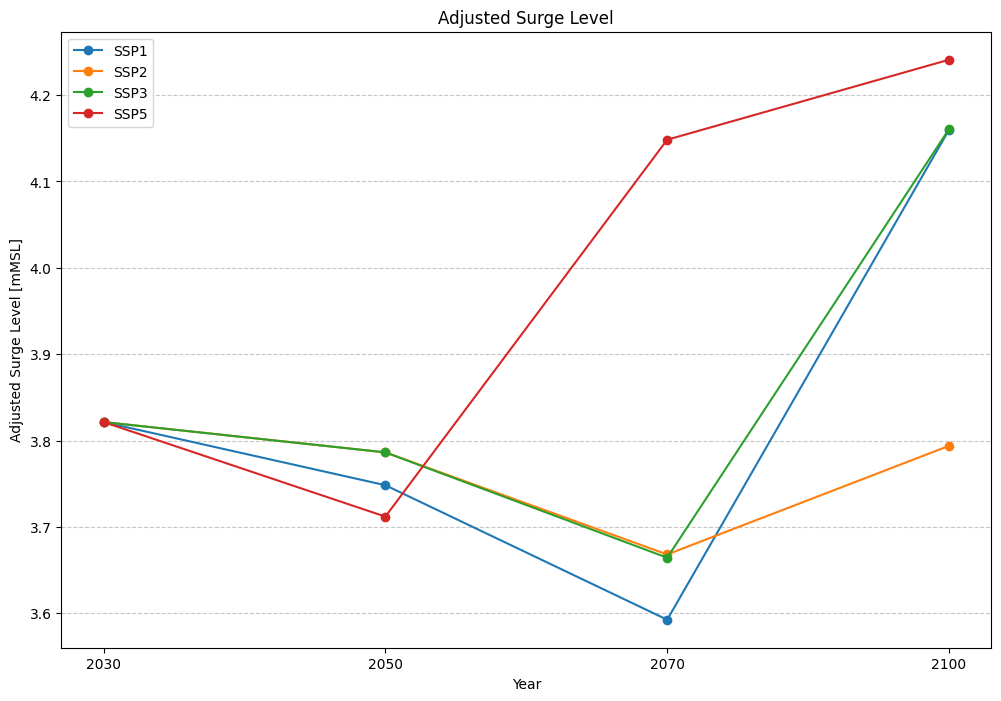

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
surge_levels.plot(ax=ax, marker='o')
ax.set_title('Adjusted Surge Level')
ax.set_ylabel('Adjusted Surge Level [mMSL]')
ax.set_xlabel('Year')
ax.set_xticks(range(len(horizons)))
ax.set_xticklabels(horizons)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

## Inundation Depths

### Calculate Inundation Area from Pixel Resolution

In [30]:
import math

def calculate_pixel_area(lat, pixel_width_deg, pixel_height_deg):
    """Calculate area of a WGS84 pixel in square meters given its latitude and dimensions in degrees"""
    # WGS84 ellipsoid parameters
    a = 6378137.0  # Semi-major axis (equatorial radius) in meters
    b = 6356752.314245  # Semi-minor axis (polar radius) in meters
    e_sq = 1 - (b*b)/(a*a)  # Eccentricity squared
    
    # Calculate meters per degree
    lon_meters_per_deg = (math.pi/180) * a * math.cos(math.radians(lat)) / math.sqrt(1 - e_sq * math.pow(math.sin(math.radians(lat)), 2))
    lat_meters_per_deg = (math.pi/180) * a * (1 - e_sq) / math.pow(1 - e_sq * math.pow(math.sin(math.radians(lat)), 2), 1.5)
    
    # Calculate area
    return pixel_width_deg * lon_meters_per_deg * pixel_height_deg * lat_meters_per_deg

def calculate_flood_area(raster_path):
    # Open the raster file
    with rio.open(raster_path) as src:
        # Get the transform and dimensions
        transform = src.transform
        height = src.height
        width = src.width
        
        # Extract the pixel width and height in degrees
        pixel_width_deg = abs(transform[0])
        pixel_height_deg = abs(transform[4])
        
        # Read the raster data
        data = src.read(1).astype(float)  # Assuming single band raster and we're working with float type that can handle NaN
        data[data == -99999.0] = np.nan
        
        # Create a mask of valid (non-NaN) pixels
        valid_mask = ~np.isnan(data)
        valid_count = np.sum(valid_mask)
        
        # Get bounds
        bounds = src.bounds
        
        # Calculate total area of non-NaN pixels
        total_area = 0
        
        # Create an array of latitudes for each row
        # First, get the latitude of the top edge
        top_lat = bounds.top
        
        # For each row, calculate the latitude at the center of the pixels
        for row in range(height):
            # Calculate latitude at the center of this row of pixels
            # (subtract half a pixel to get to the center of the first pixel,
            # then subtract the appropriate number of pixels for the current row)
            row_lat = top_lat - (pixel_height_deg * (row + 0.5))
            
            # Calculate pixel area at this latitude
            pixel_area = calculate_pixel_area(row_lat, pixel_width_deg, pixel_height_deg)
            
            # Count valid pixels in this row and add their area to the total
            valid_pixels_in_row = np.sum(valid_mask[row, :])
            total_area += valid_pixels_in_row * pixel_area
        
        #print(f"Number of valid (non-NaN) pixels: {valid_count}")
        #print(f"Total area of valid pixels: {total_area:.2f} square meters ({total_area/1000000:.4f} square kilometers)")

        return total_area, valid_count

### Timeseries

In [47]:
from datetime import timedelta
from datetime import datetime, timedelta

def get_nc_time_datetimes(nc_path):
    """
    Given a netCDF file path, extract the time variable and units,
    and return a list of datetime objects corresponding to each time step.
    """
    nc = netcdf.Dataset(nc_path, 'r')
    time_seconds = nc['time'][:]
    units_str = nc['time'].units
    date_str = units_str.split('since')[-1].strip()
    base_datetime = datetime.strptime(date_str, "%Y-%m-%d %H:%M")
    # Convert to hours, minutes, and seconds
    time_hms = [str(timedelta(seconds=float(t))).split('.')[0][:-3] for t in time_seconds]
    new_datetimes = []
    for t in time_hms:
        days_part, time_part = t.split(', ')
        days = int(days_part.split()[0])
        hours, minutes = map(int, time_part.split(':'))
        delta = timedelta(days=days, hours=hours, minutes=minutes)
        new_dt = base_datetime + delta
        new_datetimes.append(new_dt)
    return new_datetimes

# Example usage:
root_test = f'../sims/Gonave_SLR_mangrove/'
nc_swan_path = f'{root_test}S0/hotstart/fort.63.nc'
surge_times = get_nc_time_datetimes(nc_swan_path)
print(surge_times)

[datetime.datetime(2016, 9, 28, 14, 24), datetime.datetime(2016, 9, 28, 16, 49), datetime.datetime(2016, 9, 28, 19, 14), datetime.datetime(2016, 9, 28, 21, 39), datetime.datetime(2016, 9, 29, 0, 4), datetime.datetime(2016, 9, 29, 2, 29), datetime.datetime(2016, 9, 29, 4, 54), datetime.datetime(2016, 9, 29, 7, 19), datetime.datetime(2016, 9, 29, 9, 44), datetime.datetime(2016, 9, 29, 12, 8), datetime.datetime(2016, 9, 29, 14, 33), datetime.datetime(2016, 9, 29, 16, 58), datetime.datetime(2016, 9, 29, 19, 23), datetime.datetime(2016, 9, 29, 21, 48), datetime.datetime(2016, 9, 30, 0, 13), datetime.datetime(2016, 9, 30, 2, 38), datetime.datetime(2016, 9, 30, 5, 3), datetime.datetime(2016, 9, 30, 7, 28), datetime.datetime(2016, 9, 30, 9, 52), datetime.datetime(2016, 9, 30, 12, 17), datetime.datetime(2016, 9, 30, 14, 42), datetime.datetime(2016, 9, 30, 17, 7), datetime.datetime(2016, 9, 30, 19, 32), datetime.datetime(2016, 9, 30, 21, 57), datetime.datetime(2016, 10, 1, 0, 22), datetime.datet

,S0
2016-10-04 10:28:00,13.263518
2016-10-04 12:53:00,13.967105
2016-10-04 15:18:00,26.503200
2016-10-04 17:43:00,47.976596
2016-10-04 20:08:00,100.589582
2016-10-04 22:33:00,111.432224
2016-10-05 00:58:00,140.833733
2016-10-05 03:22:00,145.696876
2016-10-05 05:47:00,145.309384
2016-10-05 08:12:00,142.774272


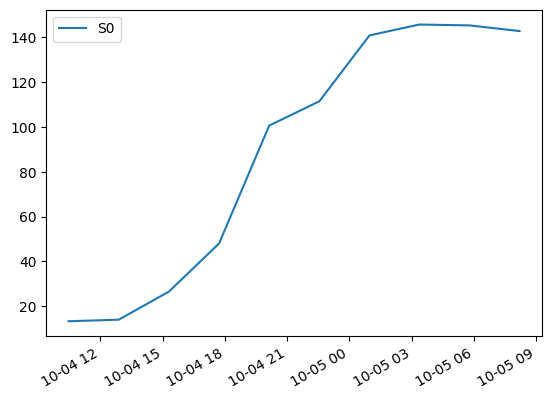

In [50]:
inundations_ts = pd.DataFrame(index=surge_times[58:68], columns=['S0'])
ts = np.arange(58, 68)

inun = []
for i in ts:
    tail = f'_ts_{i}_flood_depths_exported.tif'
    path = f'{root_test}S0/timesteps_floods/S0{tail}'
    area, valid_n = calculate_flood_area(path)
    area = area / 1000000 # Convert to km²
    inun.append(area)

inundations_ts['S0'] = inun
inundations_ts.plot()
inundations_ts

In [ ]:
19.4, -74.74
19.3, -74.62

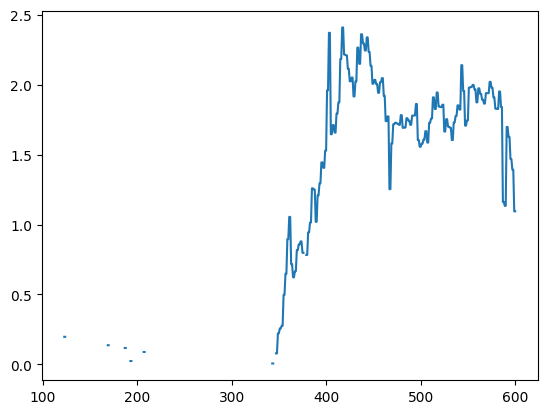

In [ ]:
from shapely.geometry import LineString
import rasterio
import numpy as np

def extract_raster_along_transect(raster_path, transect_coords):
    """
    Extract raster values along a transect defined by a list of (lon, lat) tuples.
    Returns the coordinates and the corresponding raster values.
    """
    # Open the raster
    with rasterio.open(raster_path) as src:
        # Create a LineString from the transect coordinates
        line = LineString(transect_coords)
        # Sample points along the line (interpolate to pixel resolution)
        num_points = int((line.length / np.max([abs(src.res[0]), abs(src.res[1])])) * 2)
        sampled_points = [line.interpolate(float(i)/num_points, normalized=True) for i in range(num_points + 1)]
        lonlats = [(pt.x, pt.y) for pt in sampled_points]
        # Convert lon/lat to row/col
        rows_cols = [src.index(lon, lat) for lon, lat in lonlats]
        # Extract raster values
        values = []
        for row, col in rows_cols:
            if 0 <= row < src.height and 0 <= col < src.width:
                val = src.read(1)[row, col]
                if val == src.nodata:
                    val = np.nan
                values.append(val)
            else:
                values.append(np.nan)
        return lonlats, values

# Example usage:
transect_coords = [(-72.74, 19.4), (-72.62, 19.4)]
tail =  f'_ts_{68}_flood_depths_exported.tif' # Replace with your transect coordinates
raster_path = f'{root_test}S0/timesteps_floods/S0{tail}'  # Use the raster path variable already defined
coords, vals = extract_raster_along_transect(raster_path, transect_coords)


plt.plot(vals)

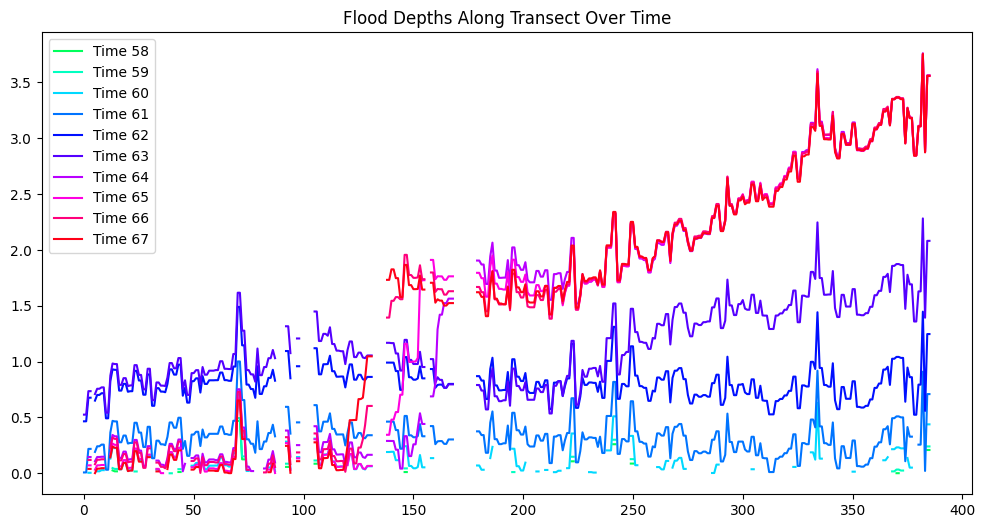

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

transect_coords = [(-72.73, 19.365), (-72.62, 19.293)]
ts = np.arange(58, 68)

colors = plt.cm.hsv(np.linspace(0.4, 1, len(ts)))

for idx, i in enumerate(ts):
    tail =  f'_ts_{i}_flood_depths_exported.tif'
    path = f'{root_test}S0/timesteps_floods/S0{tail}'
    coords, vals = extract_raster_along_transect(path, transect_coords)
    ax.plot(vals, label=f'Time {i}', color=colors[idx])
ax.set_title('Flood Depths Along Transect Over Time')
ax.legend()

In [ ]:
tail = '_flood_depths_exported.tif'

inundations = pd.DataFrame(index=horizons, columns=scenarios)

for scenario in scenarios:
    inun = []
    for year in horizons:
        path = f'{root}{scenario}_{year}/{scenario}_{year}{tail}'
        #print(path)
        area, valid_n = calculate_flood_area(path)
        area = area / 1000000 # Convert to km²
        inun.append(area)
    inundations[scenario] = inun

inundations

,SSP1,SSP2,SSP3,SSP5
2030,154.342458,154.342458,154.342458,154.342458
2050,159.841569,159.661142,159.661142,158.930466
2070,161.223984,169.708361,163.511239,174.347848
2100,175.240098,174.467886,182.793927,179.443561


In [ ]:
pd.date_range(start='2030-01-01', periods=len(horizons), freq='10Y')

In [ ]:
timesteps = pd.date_range(start='2030-01-01', periods=len(horizons), freq='10Y')
inundations_ts = pd.DataFrame(index=timesteps, columns=['S0'])

In [ ]:
pct_change_from_base = inundations.divide(inundations.iloc[0], axis="columns") - 1
pct_change_from_base.head()

,SSP1,SSP2,SSP3,SSP5
2030,0.000000,0.000000,0.000000,0.000000
2050,0.035629,0.034460,0.034460,0.029726
2070,0.044586,0.099557,0.059405,0.129617
2100,0.135398,0.130395,0.184340,0.162633


In [ ]:
pct_change_yrly = inundations.pct_change(axis=0) * 100
pct_change_yrly

,SSP1,SSP2,SSP3,SSP5
2030,NaN,NaN,NaN,NaN
2050,3.562928,3.446028,3.446028,2.972616
2070,0.864866,6.292839,2.411418,9.700709
2100,8.693567,2.804532,11.792882,2.922728


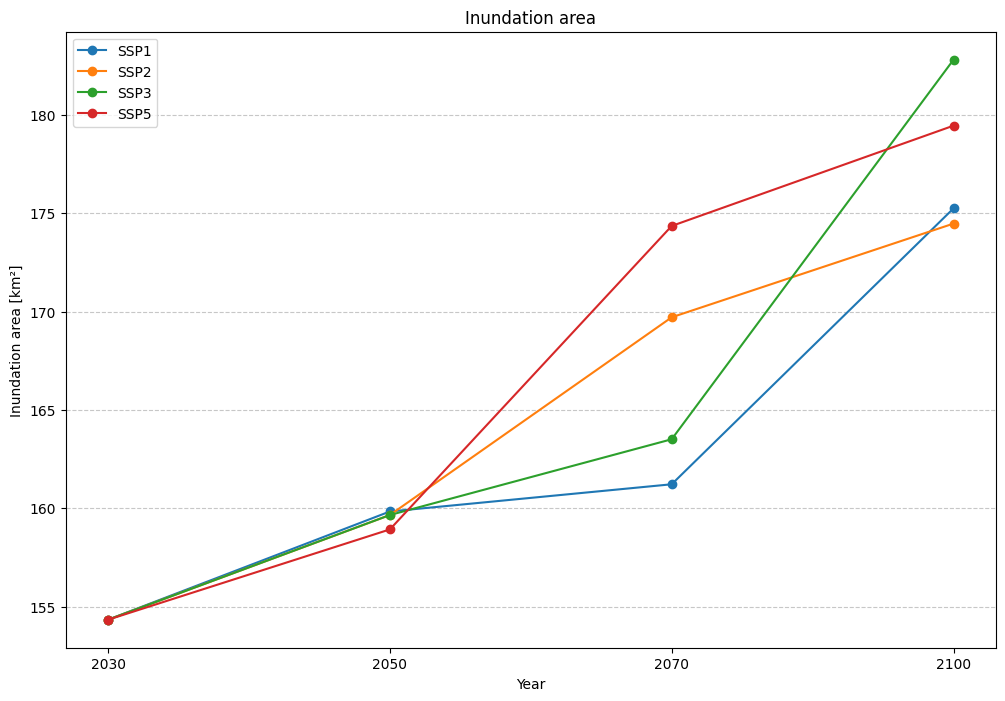

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
inundations.plot(ax=ax, marker='o')
ax.set_title('Inundation area')
ax.set_ylabel('Inundation area [km²]')
ax.set_xlabel('Year')
ax.set_xticks(range(len(horizons)))
ax.set_xticklabels(horizons)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

## Difference Maps

### Inundation Extent

Text(0.5, 1.0, 'Inundation Extent Evolution for SSP2')

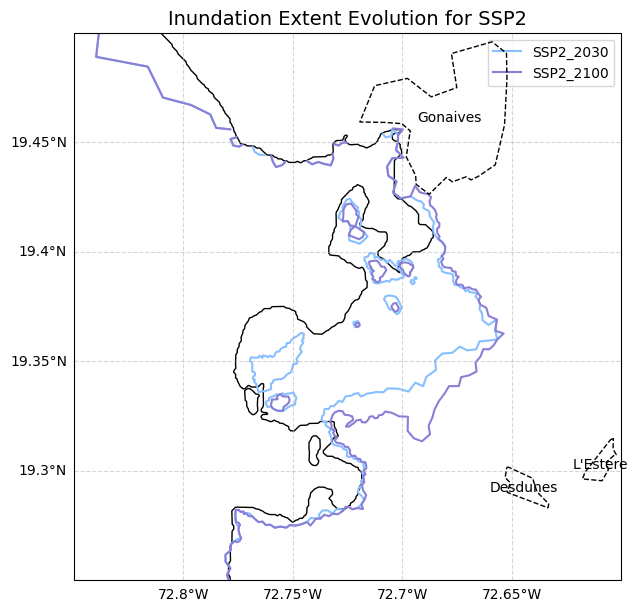

In [ ]:
def plot_flood_extent(run, ax, color, scenario, year):
    tri = mpl.tri.Triangulation(run['x'][:].data, run['y'][:].data, run['element'][:,:] - 1)
    aux = run.variables['zeta_max'][:].data

    ax.tricontour(tri, aux, levels=0, colors=color, extend='neither')
    ax.set_xlim(-72.85, -72.6)
    ax.set_ylim(19.25, 19.5)

fig, ax = plt.subplots(figsize = (8,6), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)

scenario = 'SSP2'

custom_gradient = ['#87BFFF', '#8A7FD7', '#8C40B0', '#8F0088']

for i, year in enumerate(horizons):
    plot_flood_extent(data[scenario][year], ax, custom_gradient[i], scenario, year)
    
    
cities_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--', zorder=10)
cities = ['Desdunes', "L'Estere", 'Gonaives']
for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
        ax.text(x, y, str(label), fontsize=10, color='black', ha='center', va='center', zorder=11)

ax.legend(handles=[mpl.lines.Line2D([], [], color=color, label=f'{scenario}_{year}') for color, year in zip(custom_gradient, horizons)], loc='upper right')
ax.set_xlim(-72.85, -72.6)
ax.set_ylim(19.25, 19.5)

gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10) 
gl.top_labels = False
gl.right_labels = False

coast = cf.GSHHSFeature(scale='full', levels=[1,2,3,4], alpha=1.0, edgecolor='black')
ax.add_feature(cf.LAKES)
ax.add_feature(coast)

ax.set_title(f'Inundation Extent Evolution for {scenario}', fontsize=14)

### Baseline Diff No Mangrove - Mangrove

In [ ]:
import matplotlib.patheffects as path_effects

def compute_diff(path_base_mangrove, path_base_nomangrove):
    base_mangrove = rxr.open_rasterio(path_base_mangrove)
    base_nomangrove = rxr.open_rasterio(path_base_nomangrove)

    base_mangrove = base_mangrove.where(base_mangrove != base_mangrove.attrs['_FillValue'], np.nan)
    base_nomangrove = base_nomangrove.where(base_nomangrove != base_nomangrove.attrs['_FillValue'], np.nan)

    diff = base_mangrove - base_nomangrove
    return diff


def plot_diff(diff, title):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)
    # Convert from NGVD29 to NAVD88 using an approximate offset (https://pubs.usgs.gov/sir/2010/5040/section.html)

    norm = colors.TwoSlopeNorm(vmin=diff.min(), vcenter=0, vmax=diff.max())

    n = diff.plot(ax=ax, cmap=cmocean.cm.balance, zorder=10, norm=norm, cbar_kwargs={'label': 'Difference in flood depth [m]'})
    cbar = n.colorbar
    cbar.set_label('Difference in flood depth [m]', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_yscale('linear')

    cities_gdf.plot(ax=ax, edgecolor='white', facecolor='gray', alpha=0.1, linestyle='--', zorder=10)
    cities_gdf.plot(ax=ax, edgecolor='white', facecolor='none', linestyle='--', zorder=10)
    cities = ['Desdunes', "L'Estere", 'Gonaives']
    for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
        t = ax.text(
            x, y, str(label),
            fontsize=10,
            color='white',
            ha='center',
            va='center',
            zorder=11,
        )
        t.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                       path_effects.Normal()])

    ax.set_xlim(-72.85, -72.58)
    ax.set_ylim(19.23, 19.5)

    print(diff.min(), diff.max())  

    ax.set_title(title, fontsize=16)

    #coastline = cf.GSHHSFeature(scale='full', levels=[1,2,3,4], alpha=1.0, edgecolor='black')
    #ax.add_feature(coastline, zorder=1)
    #ax.add_feature(cf.BORDERS, linestyle='--', alpha=0.5)

    gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10) 
    gl.top_labels = False
    gl.right_labels = False
    # Export the plot with a transparent background
    plt.savefig(f"exports/figures/{title}.png", dpi=600, bbox_inches='tight', transparent=True)

In [ ]:
path_base_mangrove = f'{root}S0/S0{tail}'
path_base_nomangrove = f'{root_nomangrove}S0/S0{tail}'
diff = compute_diff(path_base_mangrove, path_base_nomangrove)

<xarray.DataArray ()> Size: 4B
array(-2.7433043, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0 <xarray.DataArray ()> Size: 4B
array(1.2680695, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0


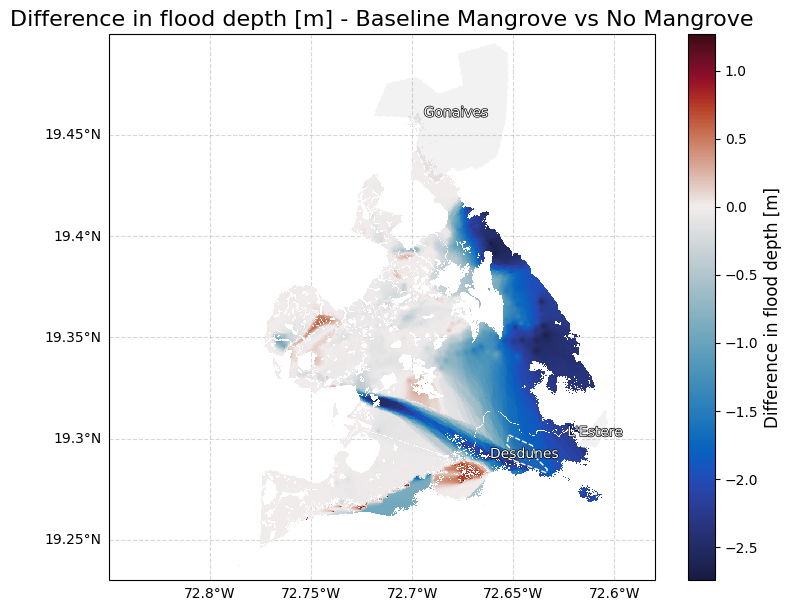

In [ ]:
plot_diff(diff, 'Difference in flood depth [m] - Baseline Mangrove vs No Mangrove')

In [ ]:
scenario = 'SSP1'
year = '2030'
path_ssp1 = f'{root}{scenario}_{year}/{scenario}_{year}{tail}'
path_ssp1_nomang = f'{root_nomangrove}{scenario}_{year}/{scenario}_{year}{tail}'

diff = compute_diff(path_ssp1, path_ssp1_nomang)

<xarray.DataArray ()> Size: 4B
array(-2.7433043, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0 <xarray.DataArray ()> Size: 4B
array(1.2680695, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0


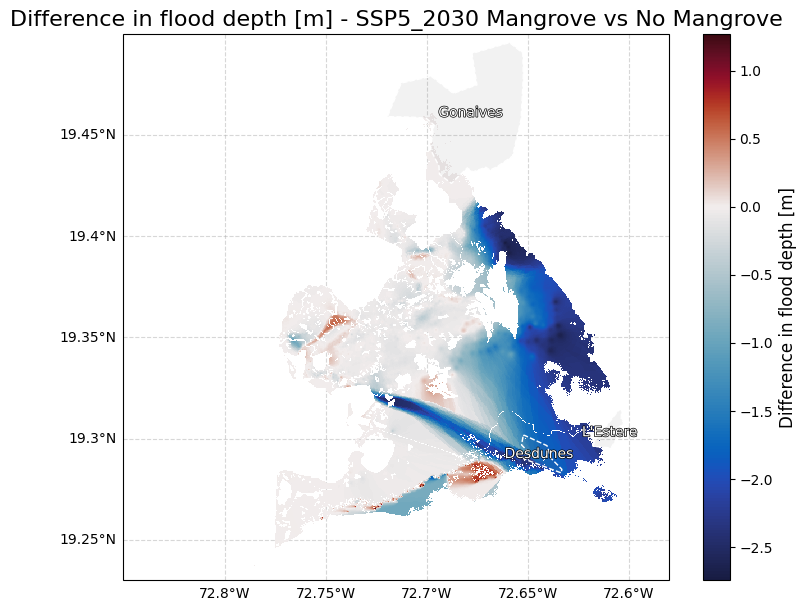

In [ ]:
plot_diff(diff, f'Difference in flood depth [m] - {scenario}_{year} Mangrove vs No Mangrove')

<xarray.DataArray ()> Size: 4B
array(-3.3410442, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0 <xarray.DataArray ()> Size: 4B
array(0.76611793, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0


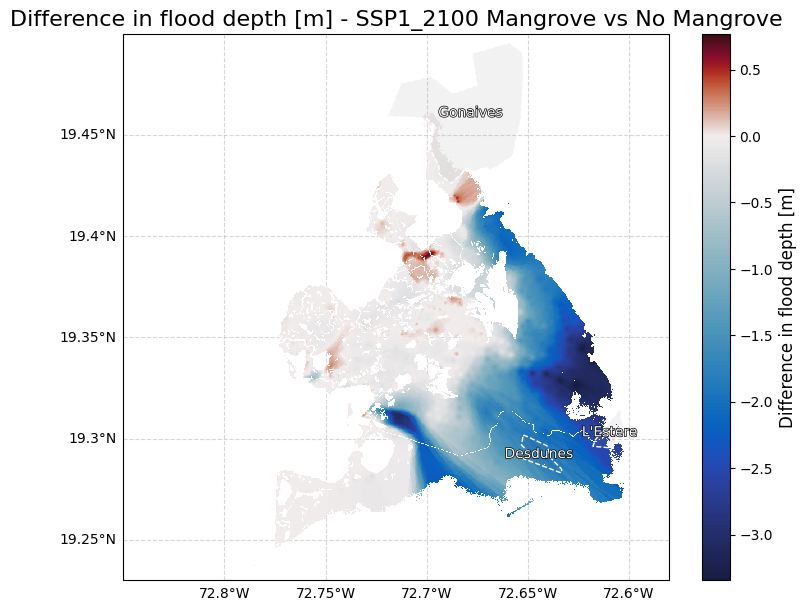

In [ ]:
scenario = 'SSP1'
year = '2100'
path_ssp1 = f'{root}{scenario}_{year}/{scenario}_{year}{tail}'
path_ssp1_nomang = f'{root_nomangrove}{scenario}_{year}/{scenario}_{year}{tail}'

diff = compute_diff(path_ssp1, path_ssp1_nomang)
plot_diff(diff, f'Difference in flood depth [m] - {scenario}_{year} Mangrove vs No Mangrove')

<xarray.DataArray ()> Size: 4B
array(-2.6830554, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0 <xarray.DataArray ()> Size: 4B
array(0.83870804, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0


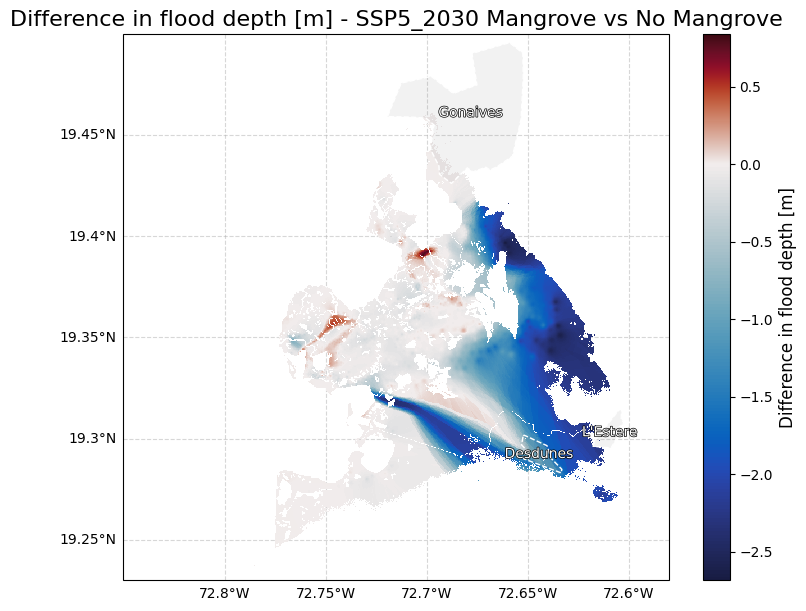

In [ ]:
scenario = 'SSP5'
year = '2030'
path_ssp1 = f'{root}{scenario}_{year}/{scenario}_{year}{tail}'
path_ssp1_nomang = f'{root_nomangrove}{scenario}_{year}/{scenario}_{year}{tail}'

diff = compute_diff(path_ssp1, path_ssp1_nomang)
plot_diff(diff, f'Difference in flood depth [m] - {scenario}_{year} Mangrove vs No Mangrove')

<xarray.DataArray ()> Size: 4B
array(-2.8523881, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0 <xarray.DataArray ()> Size: 4B
array(0.42774916, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0


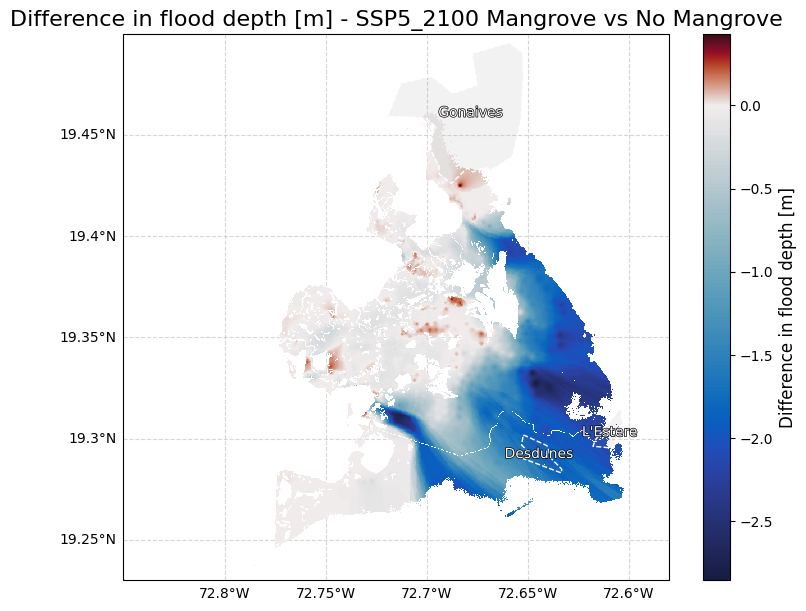

In [ ]:
scenario = 'SSP5'
year = '2100'
path_ssp1 = f'{root}{scenario}_{year}/{scenario}_{year}{tail}'
path_ssp1_nomang = f'{root_nomangrove}{scenario}_{year}/{scenario}_{year}{tail}'

diff = compute_diff(path_ssp1, path_ssp1_nomang)
plot_diff(diff, f'Difference in flood depth [m] - {scenario}_{year} Mangrove vs No Mangrove')